![alt text](img/LM.png)
# Kurs: Warsztaty Machine learning w Pythonie

## Prowadzący: Piotr Ćwiakowski

## Autorzy: Piotr Ćwiakowski, Maciej Wilamowski

### Lekcja 8. Wprowadzenie do ensemblingu

#### Spis treści:

1. Wprowadzenie do ensemblingu
2. Proste uśrednianie wyników modeli
3. Stacking modeli

# 1. Wprowadzenie do łączenia modeli

## 1.1. Przykład wariancji i wartości oczekiwanej
Jak podpowiada rachunek prawdopodobieństwa wariancja błędu oszacowania zależeć będzie od liczby prób. Żeby zrozumieć to spójrzmy na prosty problem ilustracyjny. Jeżeli gralibyśmy z kimś w orła i reszkę, tak, że albo wygrywamy albo przegrywamy 10 zł to możliwe nasze wygrane wyglądają następująco:
* (-10, 0.5),  (10, 0.5)
* (-20, 0.25), (0, 0.5), (20, 0.25)
* (-30, 0.125), (-10, 0.375), (10, 0.375), (30, 0.125)
* ...
Z jednej strony z kolejnymi powtórzeniami maksymalna teoretyczna wygrana/przegrana rośnie, ale wartości minimalne i maksymalne mają coraz mniejsze prawdopodobieństwa. Kiedy gramy kilkukrotnie to wygrane i przegrane w kolejnych partiach mogą się "znieść".

O ile w grze w orła i reszkę mieliśmy za kazdym razem 10zł za rundę to wyobraźmy sobie teraz, że zamiast tego mówimy, że 10zł jest za całą grę, a jedna runda to wygrana lub przegrana 10/k, gdzie k to liczba rund. Wtedy dostaniemy
* (-10, 0.5),  (10, 0.5)
* (-10, 0.25), (0, 0.5), (10, 0.25)
* (-10, 0.125), (-3.3, 0.375), (3.3, 0.375), (10, 0.125)
* ...

Nagle widać, że prawdopodobieństwo uzyskania wartości bliższej wartości oczekiwanej wynoszącej zero znacząco rośnie.

# 2. Uśrednianie wyników modeli
Jeżeli przypomnimy sobie zajęcia o walidacji krzyżowej, to zauważymy, ze w modelowaniu też mamy doczynienia z wartością oczekiwaną (bias) i wariancją błędu oszacowania (variance). Może warto więc wykorzystać powyższy "trik" do tego aby robić lepsze modele machine learningu? Jak możemy powtórzyć grę i zmniejszyć stawkę?

Jeżeli mamy predykcje trzech różnych algorytmów (Ekonometria, SVM, kNN) to predykcję każdego z nich możemy uznać za kolejny eksperyment/powtórzenie. Jednocześnie zamiast oddawać cały głos (pełną stawkę) jednemu z nich, możemy te głosy podzielić i zmniejszyć stawkę.

**Uwaga** Oczywiście zmniejszanie wariancji zadziała bardzo dobrze tylko w przypadku zdarzeń niezależnych. W oczywisty sposób nasze modele będą od siebie zależne, ponieważ zostały stworzone na tych samych danych. Niemniej warto spróbować i zobaczyć czy coś się poprawi.

In [1]:
import pandas as pd
import numpy as np
import pickle
import statsmodels.api as sm
from sklearn import metrics

import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')
%matplotlib inline

import gc

In [2]:
df = pd.read_csv("data/bank-balanced.csv")
print(df.shape)
df.head()

(11162, 17)


age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no     2343     yes   no  unknown   
1   56      admin.  married  secondary      no       45      no   no  unknown   
2   41  technician  married  secondary      no     1270     yes   no  unknown   
3   55    services  married  secondary      no     2476     yes   no  unknown   
4   54      admin.  married   tertiary      no      184      no   no  unknown   

   day month  duration  campaign  pdays  previous poutcome deposit  
0    5   may      1042         1     -1         0  unknown     yes  
1    5   may      1467         1     -1         0  unknown     yes  
2    5   may      1389         1     -1         0  unknown     yes  
3    5   may       579         1     -1         0  unknown     yes  
4    5   may       673         2     -1         0  unknown     yes

In [3]:
df.columns
target = "deposit"

In [4]:
import pickle
# Wczytajmy też wcześniej zapisane modele
with open("model_ekonometria_1.p", "rb") as fp:
    modelEkonometria = pickle.load(fp)
    
with open("model_svm_1.p", "rb") as fp:
    modelSVM = pickle.load(fp)
    
with open("model_kNN_1.p", "rb") as fp:
    modelkNN = pickle.load(fp)

### Porównanie wyników z dotychczasowych modeli

In [5]:
from helpers import plotROCs

Tym razem kiedy będziemy wczytywać predykcje dotychczasowych modeli możemy dodać wartości predykcji jako kolumny do naszego zbioru.

In [6]:
df[target] = (df[target]=="yes").astype(int)

In [7]:
res2plot = []
predNames = []
true = df[target].sort_index()
for result in [modelkNN, modelEkonometria, modelSVM]:
    # Tworzymy wektor predykcji tworząc serię pandasa, a następnie sortujemy indeks
    pred = pd.Series(sum(result["predictions"], []), index=sum(result["indices"], [])).sort_index()
    # Dodajmy kolumnę z predykcjami na podstawie nazwy z pliku
    # Wyczyścimy nazwy modeli aby zlikwidować spacje i pozbyć się niepotrzebnych składników
    cleanName = (result['name']).replace(" ", "_").split("_")[0]
    predNames.append(f"pred_{cleanName}")
    df[f"pred_{cleanName}"] = pred
    res2plot.append((true, pred, result["name"]))


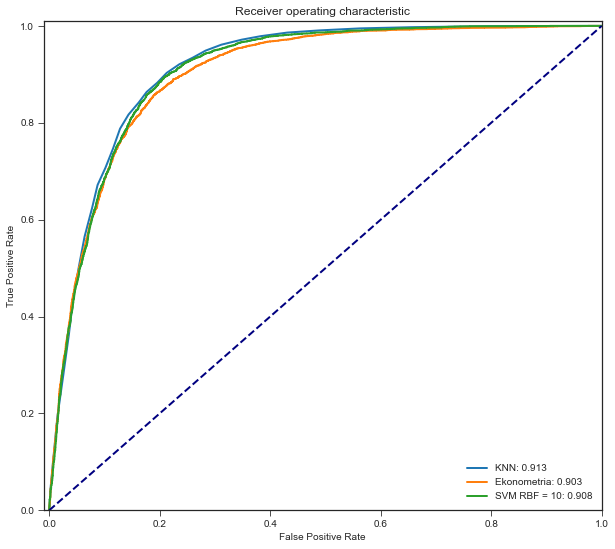

In [8]:
# Wywołujemy funkcję do rysowania
plotROCs(res2plot)

Spójrzmy na przykładowe predykcje z tych trzech modeli. Z jednej strony widać pewną korelację, ale jednocześnie widzimy też pewną różnorodność.

In [9]:
df[predNames].sample(10)

pred_KNN  pred_Ekonometria  pred_SVM
7196   0.533333          0.368109  0.637355
3979   0.800000          0.758115  0.872052
4338   0.966667          0.991090  0.934766
1016   0.866667          0.975711  0.939824
234    0.866667          0.976733  0.962438
10769  0.000000          0.157541  0.140770
6270   0.100000          0.178628  0.027889
9592   0.000000          0.008708  0.005886
9666   0.033333          0.067766  0.078894
9049   0.000000          0.106816  0.058706

In [10]:
df[predNames].corr()

pred_KNN  pred_Ekonometria  pred_SVM
pred_KNN          1.000000          0.932692  0.907288
pred_Ekonometria  0.932692          1.000000  0.875143
pred_SVM          0.907288          0.875143  1.000000

Możemy zobaczyć, który model jak często daje największą i najmniejszą wartość. Zdecydowanie potwierdza to naszą obserwację dotyczącą tego, że wyniki są naprawdę różnorodne. Żaden z modeli nie daje zawsze większych czy mniejszych predykcji niż pozostałe.

In [11]:
print(df[predNames].idxmax(axis=1).value_counts())
print(df[predNames].idxmin(axis=1).value_counts())

pred_Ekonometria    5253
pred_SVM            4077
pred_KNN            1832
dtype: int64
pred_KNN            5188
pred_SVM            3517
pred_Ekonometria    2457
dtype: int64


Sprawdźmy jak zachowa się średnia z modeli.

In [12]:
df["pred_mean"] = df[predNames].mean(axis=1)
# df["pred_mean"] = df[['pred_KNN','pred_SVM']].mean(axis=1)

In [13]:
res2plot.append((true, df["pred_mean"].sort_index().tolist(), "mean_pred"))

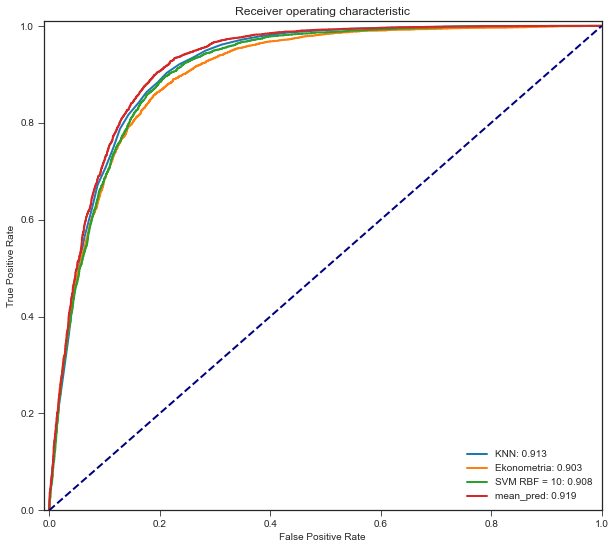

In [14]:
# Wywołujemy funkcję do rysowania
plotROCs(res2plot)

Jak widać, przez zastosowanie zwykłej średniej z dotychczasowych prognoz uzyskaliśmy zdecydowanie najlepszy wynik. Siła modelu predykcyjnego oparta o średnią z trzech tylko składników jest większa niż wszystkich składowych. Wynik ten jest rewelacyjny biorąc pod uwagę to, że policzylismy po prostu średnią. Pomimo tego, że niektóre modele już wcześniej były słabsze, a inne mocniejsze, to prognoza każdego z nich weszła do nowej prognozy z tą samą wagą.

Może należy inaczej dobrać wagi?

# 3. Stacking
Zamiast liczyć średnią czy też dobierać wagi programistycznie możemy zobaczyć co się stanie kiedy predykcje z trzech wcześniejszych modeli użyjemy jako zmienne w regresji logistycznej.

**Uwaga.** Zauważmy, że zmienne będą silnie skorelowane, więc regresja logistyczna może nie być najlepszym narzędziem. Dodatkowo przy tak zaprojektowanej procedurze będziemy mieli do czynienia ze swego rodzaju "przeciekaniem" wiedzy w procesie walidacji krzyżowej.

In [15]:
import statsmodels.api as sm
mod = sm.GLM.from_formula(formula="deposit ~ "+"+".join(predNames),
                          data=df, family=sm.families.Binomial())
res = mod.fit()
predsStack = res.predict()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                deposit   No. Observations:                11162
Model:                            GLM   Df Residuals:                    11158
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3988.3
Date:                Sat, 04 Dec 2021   Deviance:                       7976.6
Time:                        12:38:53   Pearson chi2:                 1.03e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.4877
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -3.3950      0.063    -53.693      0.000      -3.519      -3.271
pred_KNN             3.4414      0.239     14.405      0.000       2.973       3.910
pred_Ekonometria     0.7747      0.197      3.933      0.000       0.389       1.161
pred_SVM             2.6164      0.158     16.518      0.000       2.306       2.927
====================================================================================
"""

Zobaczmy, jak taka predykcja spisze się w porównaniu ze zwykłym uśrednianiem

In [16]:
df["pred_stack_logisitc"] = predsStack

In [17]:
res2plot.append((true, df["pred_stack_logisitc"].sort_index().tolist(), "pred_stack_logisitc"))

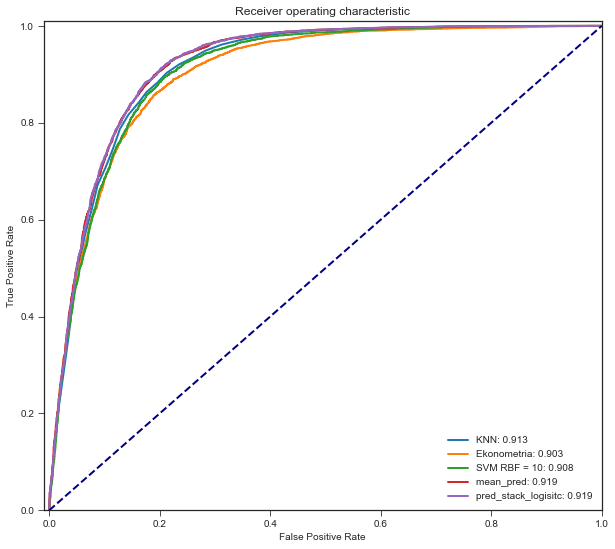

In [18]:
# Wywołujemy funkcję do rysowania
plotROCs(res2plot)

Jak widać nie obserwujemy znaczącej poprawy względem zwykłej średniej. Jednocześnie wyniki modelu regresji logistycznej pokazują charakterystyczny problem dla współliniowości. Każda zmienna dostała oszacowanie dodatnie, a dwie mają oszacowanie większe niż 1. Wszystko jest "offsetowane" przez ujemną stałą. 

Możemy z tego wywnioskować, coś co wiedzieliśmy już wcześniej. Oszacowanie kNN jest relatywnie najlepsze, na drugim miejscu SVM, a na trzecim ekonometria. Możemy wielkości metryk dla poszczególnych modeli lub tak uzyskane oszacowania potraktować jako przesłankę do ważenia prawdopodobieństw.

Przykładowo możemy ręcznie dobrać wagi, 3, 2, 1 dla każdego z modeli. Ponieważ każda skłądowa jest naturalnie ograniczona od 0 do 1, to średnią ważoną możemy łatwo policzyć. Robiąc takie ręczne uśrednianie nie spodziewamy się doskonałych rezultatów, ale gwarantujemy sobie stabilność procesu (oszacowania w regresji lgistycznej na skorelowanych wartościach mogą zacząć przybierać bardzo wysokie wartości).

In [19]:
df["pred_stack_manual"] = (3*df["pred_KNN"] + 2*df["pred_SVM"] + df["pred_Ekonometria"])/6

In [20]:
res2plot.append((true, df["pred_stack_manual"].sort_index().tolist(), "pred_stack_manual"))

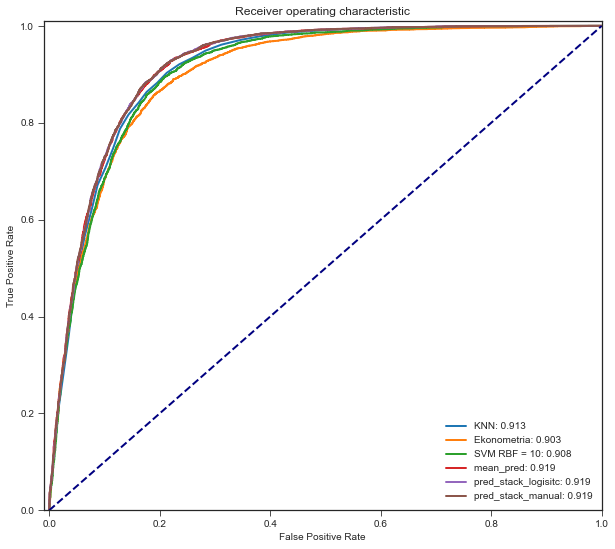

In [21]:
# Wywołujemy funkcję do rysowania
plotROCs(res2plot)

Tak stworzona średnia przypadkiem pozwolił na uzyskanie najlepszego modelu. Podkreślmy jedna fakt, iż wszystkie metody uśredniania przyniosły de facto taki sam wynik. Oczywiście jako model ważący wyniki możemy wykorzystać dowolną znaną technikę. Poniżej zamieszczamy  schemat, który wyjaśnia strukturę modelu - z tą różnicą, że zamiast RF (lasy losowe) oszacowalismy SVM.

![stacking](img/stacking.png)

Na koniec możemy jeszcze sprawdzić jak radziłby sobie stacking z KNN. Oszacujemy kilka modeli, dla coraz mniejszego k (40, 20, 10). Pokażemy dzięki temu, na czym polega przetrenowanie w stackingu, gdy model stackingowy jest trenowany na całej próbie, a nie walidacji krzyżowej.

In [23]:
from sklearn import neighbors
from sklearn.metrics import roc_auc_score

for k in [15, 20, 25, 30, 35, 40, 45, 50]:
    clf = neighbors.KNeighborsClassifier(n_neighbors=10, n_jobs=-1, p=2).fit(df[predNames], df[target])
    predsStack2 = clf.predict_proba(df[predNames])[:,1]
    roc_auc_score(df[target], predsStack2)

In [24]:
clf = neighbors.KNeighborsClassifier(n_neighbors=10, n_jobs=-1, p=2).fit(df[predNames], df[target])
predsStack2 = clf.predict_proba(df[predNames])[:,1]
df["pred_stack_knn3"] = predsStack2

In [25]:
res2plot.append((true, df["pred_stack_knn3"].sort_index().tolist(), "pred_stack_knn3"))

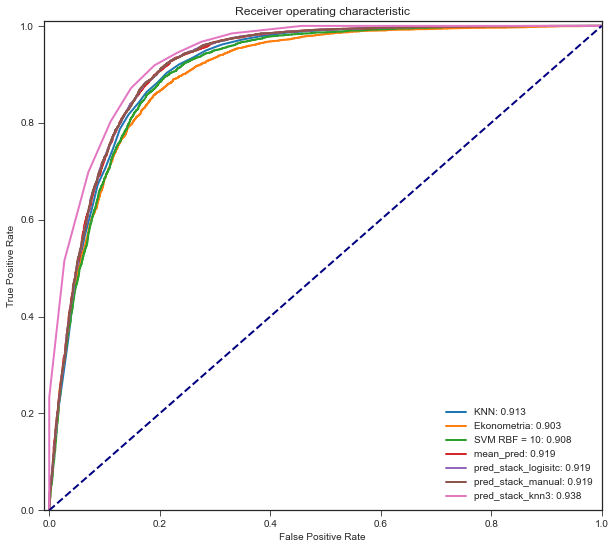

In [26]:
# Wywołujemy funkcję do rysowania
plotROCs(res2plot)

Im mniejsze k, tym model hipotetycznie lepiej jest dopasowany do danych. Ale to tylko złudzenie. Model estymuje parametry dla całego zbioru uczącego, więc wraz ze zmniejszaniem k uczy się go po prostu na pamięć. Spróbujmy oszacować stacking w walidacji krzyżowej. Nie jest to co prawda w pełni poprawna metodologicznie procedura (poprawny stacking wymaga podzielenia zbioru na trzy części), ale na nasze potrzeby będzie wystarczająco poprawna:

In [27]:
df = pd.read_csv("data/bank-balanced.csv")
numFeatures = ['age', 'balance', 'duration', 'campaign', 'pdays','previous', 'day']
catFeatures = [ 'job', 'marital', 'education', 'default',  'housing', 'loan', 'contact',  'month', 'poutcome']
# One hot encoding
dummLev = pd.get_dummies(df[catFeatures], drop_first=True)
# Połączenie zmiennych numerycznych, kategorycznych w postaci on hot encoding oraz targetu
df = pd.concat([df[numFeatures], dummLev, df[[target]]], axis=1)
# Zmienne
features = df.columns.tolist()
features = [x.replace('-', '_') for x in features]
df.columns = features
features.remove('deposit')

In [28]:
# Wczytanie potrzebnych bibliotek
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn import neighbors
from sklearn.svm import SVC
from sklearn import neighbors

# Przygotujmy wrapper
def CVTestStack(nFolds = 5, randomState=2020, debug=False, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # Listy z wynikami
    testResults = []
    trainResults = []
    predictions = []
    indices = []
    
    # Pętla walidująca model na kolejnych foldach
    for train, test in kf.split(df.index.values):
        # Przygotowanie estymatora
        clf1 = neighbors.KNeighborsClassifier(n_neighbors=30, n_jobs=-1, p=1)
        clf2 = sm.GLM.from_formula(
            formula="deposit ~ "+"+".join(features),
            data=df.iloc[train], family=sm.families.Binomial()
        )
        clf3 = SVC(C=.5, cache_size=500, kernel='rbf', max_iter=-1, probability=True, tol=0.001, verbose=False)
        if debug:
            print(clf)
        # Trenowanie modeli
        clf1.fit(df.iloc[train][features], df.iloc[train][target])
        res = clf2.fit()
        # Trenowanie modelu
        X = df.iloc[train].sample(5000)
        clf3.fit(X[features], X[target])
        # Przygotowanie prognoz dla zbioru treningowego i testowego
        preds1Train = clf1.predict_proba(df.iloc[train][features])[:,1]
        preds2Train = res.predict()
        preds3Train = clf3.predict_proba(df.iloc[train][features])[:,1]
        dfTrain = pd.DataFrame({'KNN': preds1Train, 'Logit': preds2Train, 'SVM': preds3Train})
        
        preds1Test = clf1.predict_proba(df.iloc[test][features])[:,1]
        preds2Test = res.predict(df.iloc[test][features])
        preds3Test = clf3.predict_proba(df.iloc[test][features])[:,1]
        dfTest = pd.DataFrame({'KNN': preds1Test, 'Logit': preds2Test, 'SVM': preds3Test})
        
        # Model stackingowy{'KNN': preds1Train, 'Logit': preds2Train, 'SVM': preds3Train}
        
        clf = neighbors.KNeighborsClassifier(*args, **kwargs).fit(dfTrain, df[target].iloc[train])
        predsTrain = clf.predict_proba(dfTrain)[:,1]
        preds = clf.predict_proba(dfTest)[:,1]
        
        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(preds.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Policzenie ROC-AUC dla foldów
        trainScore = roc_auc_score((df[target].iloc[train]=="yes").astype(int), predsTrain)
        testScore = roc_auc_score((df[target].iloc[test]=="yes").astype(int), preds)
        
        # Zapisanie wyników dla foldów
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices

In [29]:
for k in [15, 20, 25, 30, 35, 40, 45, 50]:
    trainResults, testResults, predictions, indices = CVTestStack(n_neighbors=k, n_jobs=-1, p=2)
    print(k, np.mean(trainResults), np.mean(testResults))

15 0.9265021523446402 0.892804406015759
20 0.9235892754128626 0.8957369921005629
25 0.9220231428223602 0.8973407623040031
30 0.9209144863756553 0.8987967201885109
35 0.9198874026812243 0.8996845752527431
40 0.9191609030155414 0.9011157213654144
45 0.9190162865186998 0.9016358457474304
50 0.9184973676575208 0.9013799003844877


Nie ma dobry efektów. Sprawdźmy jeszcze model logistyczny (jako model agregujący prognozy):

In [46]:
# Przygotujmy wrapper
def CVTestStack(nFolds = 5, randomState=2020, debug=False, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # Listy z wynikami
    testResults = []
    trainResults = []
    predictions = []
    indices = []
    
    # Pętla walidująca model na kolejnych foldach
    for train, test in kf.split(df.index.values):
        # Przygotowanie estymatora
        clf1 = neighbors.KNeighborsClassifier(n_neighbors=30, n_jobs=-1, p=1)
        clf2 = sm.GLM.from_formula(
            formula="deposit ~ "+"+".join(features),
            data=df.iloc[train], family=sm.families.Binomial()
        )
        clf3 = SVC(C=.5, cache_size=500, kernel='rbf', max_iter=-1, probability=True, tol=0.001, verbose=False)
        if debug:
            print(clf)
        # Trenowanie modeli
        clf1.fit(df.iloc[train][features], df.iloc[train][target])
        res = clf2.fit()
        # Trenowanie modelu
        X = df.iloc[train].sample(5000)
        clf3.fit(X[features], X[target])
        # Przygotowanie prognoz dla zbioru treningowego i testowego
        preds1Train = clf1.predict_proba(df.iloc[train][features])[:,1]
        preds2Train = res.predict()
        preds3Train = clf3.predict_proba(df.iloc[train][features])[:,1]
        dfTrain = pd.DataFrame({'KNN': preds1Train, 'Logit': preds2Train, 'SVM': preds3Train,
                               'deposit': df.iloc[train][target]})
        
        preds1Test = clf1.predict_proba(df.iloc[test][features])[:,1]
        preds2Test = res.predict(df.iloc[test][features])
        preds3Test = clf3.predict_proba(df.iloc[test][features])[:,1]
        dfTest = pd.DataFrame({'KNN': preds1Test, 'Logit': preds2Test, 'SVM': preds3Test})
        
        # Model stackingowy{'KNN': preds1Train, 'Logit': preds2Train, 'SVM': preds3Train}
        
        clf = sm.GLM.from_formula(formula="deposit ~ KNN + Logit + SVM", 
                                  data=dfTrain, family=sm.families.Binomial()).fit()
        predsTrain = clf.predict()
        preds = clf.predict(dfTest)
        
        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(preds.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Policzenie ROC-AUC dla foldów
        trainScore = roc_auc_score((df[target].iloc[train]=="yes").astype(int), 1-predsTrain)
        testScore = roc_auc_score((df[target].iloc[test]=="yes").astype(int), 1-preds)
        
        # Zapisanie wyników dla foldów
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices

In [47]:
trainResults, testResults, predictions, indices = CVTestStack()
print(k, np.mean(trainResults), np.mean(testResults))

50 0.9114612817878538 0.9021305212716616


Walidacja krzyżowa pokazuje, że stacking nie daje tak dobrych efektów jak można się było spodziewać po pierwszych wynikach.

## Łączenie modeli - co dalej?
Nasza próba z łączeniem modeli dała pozytywne efekty. Jednocześnie czujemy się mocno ograniczeni, przez fakt, iż posiadamy wyłącznie prognozy z trzech modeli. Wydaje się, że powinno nam się udać z tym zagadnieniem zrobić coś więcej. Rachunek prawdopodobieństwa sugeruje nam wyraźnie, że będziemy mieli tym lepsze efekty im:
* więcej prób/powtórzeń będziemy mieli,
* bardziej niezależne będą kolejne próby.

Do tej pory niezależność uzyskiwaliśmy z faktu, iż predykcje robiliśmy z użyciem innych modeli/algorytmów. Jednak liczba algorytmów nie jest jednak bardzo duża, szczególnie o podobnie wysokiej skuteczności. Jak w takim razie możemy uzyskać więcej prób? 

Odpowiedź na to pytanie jest zaskakująco prosta. Warto ten sam algorytmm wytrenować, ale na różnych obserwacjach ze zbioru treningowego i/lub wybrać inne zestawy zmiennych objaśniających. Ten prosty zabieg, zupełnie zmieni zbiory treningowe, dzięki czemu da nam więcej prób, które nie będą od siebie w pełni zależne. Opisane podejście jest nazywane baggingiem i jest wykorzystywane także w lasach losowych. Nieco inaczej będziemy postępować w boostingu (chociaż tam też wykorzystuje się koncepcje znane z bagggingu i lasów losowych) oraz w stackingu/blendingu.